In [1]:
!pip install rdkit

In [2]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator
from rdkit import RDLogger
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from xgboost import XGBRegressor

In [3]:
RDLogger.DisableLog('rdApp.*')


In [4]:
df = pd.read_csv("egfr.csv")

In [5]:
df

,Smiles,Standard Value
0,Cl.Nc1ccc2c(c1)sc1c(Nc3cccc(Br)c3)ncnc12,0.47
1,Cl.O=[N+]([O-])c1cccc2c1sc1c(Nc3cccc(Br)c3)ncnc12,158.00
2,COc1ccc2ncncc2c1,30.00
3,C=CC(=O)N1CCC[C@H]1CSc1nc(-c2ccc(F)cc2)c(-c2cc...,1.90
4,Cn1cnc2cc3ncnc(Nc4cccc(Br)c4)c3cc21,0.01
...,...,...
12145,C=CC(=O)Nc1cc(Nc2nccc(-c3cn(C)c4ccccc34)n2)c(O...,2.20
12146,C=CC(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc1OCCCN...,0.80
12147,C=CC(=O)Nc1cc(Nc2nccc(-c3cn(C)c4ccccc34)n2)c(O...,110.00
12148,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCCN1CCOCC1,2.10


In [6]:
df = df[['Smiles', 'Standard Value']].dropna().copy()


In [7]:
df

,Smiles,Standard Value
0,Cl.Nc1ccc2c(c1)sc1c(Nc3cccc(Br)c3)ncnc12,0.47
1,Cl.O=[N+]([O-])c1cccc2c1sc1c(Nc3cccc(Br)c3)ncnc12,158.00
2,COc1ccc2ncncc2c1,30.00
3,C=CC(=O)N1CCC[C@H]1CSc1nc(-c2ccc(F)cc2)c(-c2cc...,1.90
4,Cn1cnc2cc3ncnc(Nc4cccc(Br)c4)c3cc21,0.01
...,...,...
12145,C=CC(=O)Nc1cc(Nc2nccc(-c3cn(C)c4ccccc34)n2)c(O...,2.20
12146,C=CC(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc1OCCCN...,0.80
12147,C=CC(=O)Nc1cc(Nc2nccc(-c3cn(C)c4ccccc34)n2)c(O...,110.00
12148,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCCN1CCOCC1,2.10


In [8]:
df = df.drop_duplicates(subset=['Smiles', 'Standard Value'])
df = df.groupby('Smiles', as_index=False)['Standard Value'].mean()

In [9]:
df

,Smiles,Standard Value
0,Br.CC(Nc1ncnc2[nH]c(-c3ccc(O)cc3)cc12)c1ccc(C(...,4608.0
1,Br.CC(Nc1ncnc2[nH]c(-c3ccc(O)cc3)cc12)c1cccc2c...,1008.0
2,Br.CC[C@@H](Nc1ncnc2[nH]c(-c3ccc(O)cc3)cc12)c1...,4.0
3,Br.C[C@@H](Nc1ncnc2[nH]c(-c3ccc(O)cc3)cc12)c1c...,62.0
4,Br.C[C@@H](Nc1ncnc2[nH]c(-c3ccc(O)cc3)cc12)c1c...,3.8
...,...,...
7572,c1coc(-c2nnc(Cc3nc4ccccc4[nH]3)o2)c1,100000.0
7573,c1csc(-c2cc3nccc(Nc4ccc5[nH]ccc5c4)c3s2)c1,1.0
7574,c1csc(-c2cc3ncnc(Nc4ccc5[nH]ccc5c4)c3s2)c1,20.0
7575,c1csc(-c2nnc(Cc3nc4ccccc4[nH]3)o2)c1,100000.0


In [10]:
df = df[df['Standard Value'].astype(float) < 1e6]


In [11]:
df

,Smiles,Standard Value
0,Br.CC(Nc1ncnc2[nH]c(-c3ccc(O)cc3)cc12)c1ccc(C(...,4608.0
1,Br.CC(Nc1ncnc2[nH]c(-c3ccc(O)cc3)cc12)c1cccc2c...,1008.0
2,Br.CC[C@@H](Nc1ncnc2[nH]c(-c3ccc(O)cc3)cc12)c1...,4.0
3,Br.C[C@@H](Nc1ncnc2[nH]c(-c3ccc(O)cc3)cc12)c1c...,62.0
4,Br.C[C@@H](Nc1ncnc2[nH]c(-c3ccc(O)cc3)cc12)c1c...,3.8
...,...,...
7572,c1coc(-c2nnc(Cc3nc4ccccc4[nH]3)o2)c1,100000.0
7573,c1csc(-c2cc3nccc(Nc4ccc5[nH]ccc5c4)c3s2)c1,1.0
7574,c1csc(-c2cc3ncnc(Nc4ccc5[nH]ccc5c4)c3s2)c1,20.0
7575,c1csc(-c2nnc(Cc3nc4ccccc4[nH]3)o2)c1,100000.0


In [12]:
df['pIC50'] = -np.log10(df['Standard Value'] * 1e-9)


/tmp/ipython-input-12-3727317828.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pIC50'] = -np.log10(df['Standard Value'] * 1e-9)


In [13]:
df

,Smiles,Standard Value,pIC50
0,Br.CC(Nc1ncnc2[nH]c(-c3ccc(O)cc3)cc12)c1ccc(C(...,4608.0,5.336488
1,Br.CC(Nc1ncnc2[nH]c(-c3ccc(O)cc3)cc12)c1cccc2c...,1008.0,5.996539
2,Br.CC[C@@H](Nc1ncnc2[nH]c(-c3ccc(O)cc3)cc12)c1...,4.0,8.397940
3,Br.C[C@@H](Nc1ncnc2[nH]c(-c3ccc(O)cc3)cc12)c1c...,62.0,7.207608
4,Br.C[C@@H](Nc1ncnc2[nH]c(-c3ccc(O)cc3)cc12)c1c...,3.8,8.420216
...,...,...,...
7572,c1coc(-c2nnc(Cc3nc4ccccc4[nH]3)o2)c1,100000.0,4.000000
7573,c1csc(-c2cc3nccc(Nc4ccc5[nH]ccc5c4)c3s2)c1,1.0,9.000000
7574,c1csc(-c2cc3ncnc(Nc4ccc5[nH]ccc5c4)c3s2)c1,20.0,7.698970
7575,c1csc(-c2nnc(Cc3nc4ccccc4[nH]3)o2)c1,100000.0,4.000000


In [14]:
df.drop(columns=['Standard Value'], inplace=True)

/tmp/ipython-input-14-2982504977.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['Standard Value'], inplace=True)


In [15]:
df

,Smiles,pIC50
0,Br.CC(Nc1ncnc2[nH]c(-c3ccc(O)cc3)cc12)c1ccc(C(...,5.336488
1,Br.CC(Nc1ncnc2[nH]c(-c3ccc(O)cc3)cc12)c1cccc2c...,5.996539
2,Br.CC[C@@H](Nc1ncnc2[nH]c(-c3ccc(O)cc3)cc12)c1...,8.397940
3,Br.C[C@@H](Nc1ncnc2[nH]c(-c3ccc(O)cc3)cc12)c1c...,7.207608
4,Br.C[C@@H](Nc1ncnc2[nH]c(-c3ccc(O)cc3)cc12)c1c...,8.420216
...,...,...
7572,c1coc(-c2nnc(Cc3nc4ccccc4[nH]3)o2)c1,4.000000
7573,c1csc(-c2cc3nccc(Nc4ccc5[nH]ccc5c4)c3s2)c1,9.000000
7574,c1csc(-c2cc3ncnc(Nc4ccc5[nH]ccc5c4)c3s2)c1,7.698970
7575,c1csc(-c2nnc(Cc3nc4ccccc4[nH]3)o2)c1,4.000000


In [16]:
def smiles_to_morgan_fp(smiles, radius=2, n_bits=2048):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        Chem.SanitizeMol(mol)
        return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits))
    except:
        return None

df['fingerprint'] = df['Smiles'].apply(smiles_to_morgan_fp)
df = df[df['fingerprint'].notnull()].reset_index(drop=True)


/tmp/ipython-input-16-4101050737.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['fingerprint'] = df['Smiles'].apply(smiles_to_morgan_fp)


In [17]:
desc_names = [desc[0] for desc in Descriptors._descList]
calc = MolecularDescriptorCalculator(desc_names)

def calculate_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return calc.CalcDescriptors(mol)
    else:
        return None

df['descriptors'] = df['Smiles'].apply(calculate_descriptors)
df = df[df['descriptors'].notnull()].reset_index(drop=True)

In [18]:
df

,Smiles,pIC50,fingerprint,descriptors
0,Br.CC(Nc1ncnc2[nH]c(-c3ccc(O)cc3)cc12)c1ccc(C(...,5.336488,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(12.756500651661645, 12.756500651661645, 0.0, ..."
1,Br.CC(Nc1ncnc2[nH]c(-c3ccc(O)cc3)cc12)c1cccc2c...,5.996539,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(9.527569828085216, 9.527569828085216, 0.0, 0...."
2,Br.CC[C@@H](Nc1ncnc2[nH]c(-c3ccc(O)cc3)cc12)c1...,8.397940,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(9.47944890367995, 9.47944890367995, 0.0, 0.0,..."
3,Br.C[C@@H](Nc1ncnc2[nH]c(-c3ccc(O)cc3)cc12)c1c...,7.207608,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(9.466484836385956, 9.466484836385956, 0.0, 0...."
4,Br.C[C@@H](Nc1ncnc2[nH]c(-c3ccc(O)cc3)cc12)c1c...,8.420216,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(13.11337941876171, 13.11337941876171, 0.0, -0..."
...,...,...,...,...
7536,c1coc(-c2nnc(Cc3nc4ccccc4[nH]3)o2)c1,4.000000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(5.551988378684807, 5.551988378684807, 0.37602..."
7537,c1csc(-c2cc3nccc(Nc4ccc5[nH]ccc5c4)c3s2)c1,9.000000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","(4.52574016334929, 4.52574016334929, 1.0380763..."
7538,c1csc(-c2cc3ncnc(Nc4ccc5[nH]ccc5c4)c3s2)c1,7.698970,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","(4.448329790249433, 4.448329790249433, 0.84971..."
7539,c1csc(-c2nnc(Cc3nc4ccccc4[nH]3)o2)c1,4.000000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","(5.656155045351474, 5.656155045351474, 0.50699..."


In [19]:
desc_df = pd.DataFrame(df['descriptors'].tolist(), columns=desc_names)
desc_df.insert(0, 'Smiles', df['Smiles'])
desc_df['pIC50'] = df['pIC50']
desc_df.to_csv("molecular_descriptors.csv", index=False)

In [20]:
X_fp = np.stack(df['fingerprint'].values)
X_desc = np.array(df['descriptors'].tolist())
X = np.hstack((X_fp, X_desc))
y = df['pIC50'].values

# Check for infinite values and remove corresponding rows
finite_mask = np.isfinite(X).all(axis=1) & np.isfinite(y)
X = X[finite_mask]
y = y[finite_mask]
df = df[finite_mask].reset_index(drop=True)

In [21]:
df['pIC50_bin'] = pd.qcut(df['pIC50'], q=10, labels=False, duplicates='drop')
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=df['pIC50_bin'], test_size=0.2, random_state=42
)

In [22]:
print("Checking for invalid values...")
print("NaNs in X:", np.isnan(X).any())
print("Infs in X:", np.isinf(X).any())
print("NaNs in y:", np.isnan(y).any())
print("Infs in y:", np.isinf(y).any())

Checking for invalid values...
NaNs in X: False
Infs in X: False
NaNs in y: False
Infs in y: False


In [23]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (6022, 2265)
y_train shape: (6022,)


In [24]:
X_fp = np.stack(df['fingerprint'].values)
X_desc = np.array(df['descriptors'].tolist())

In [25]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_desc_scaled = scaler.fit_transform(X_desc)  # Normalize descriptor values
X = np.hstack((X_fp, X_desc_scaled))  # Combine fingerprints + scaled descriptors

In [26]:
df['pIC50_bin'] = pd.qcut(df['pIC50'], q=10, labels=False)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=df['pIC50_bin'], test_size=0.2, random_state=42
)

In [27]:
print("X_train shape:", X_train.shape)
print("Any NaN or inf:", np.isnan(X_train).any(), np.isinf(X_train).any())

X_train shape: (6022, 2265)
Any NaN or inf: False False


In [30]:
from sklearn.feature_selection import SelectFromModel
import xgboost as xgb

xgb_model = XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    random_state=42
)

# Fit the model before using it in SelectFromModel with prefit=True
xgb_model.fit(X_train, y_train)

selector = SelectFromModel(xgb_model, threshold="median", prefit=True)
X_train_sel = selector.transform(X_train)
X_test_sel = selector.transform(X_test)

In [32]:
y_pred = xgb_model.predict(X_test)

from sklearn.metrics import mean_squared_error, r2_score
rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse:.2f}")
print(f"Test R²: {r2:.2f}")

Test RMSE: 0.56
Test R²: 0.68


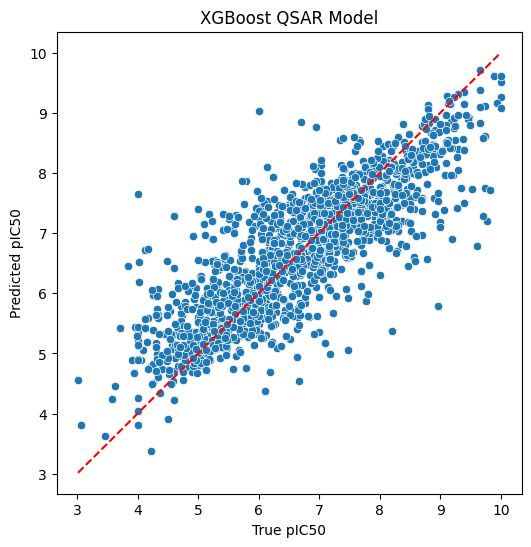

In [33]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel("True pIC50")
plt.ylabel("Predicted pIC50")
plt.title("XGBoost QSAR Model")
plt.savefig("xgboost_qsar.png")
plt.show()

In [35]:
cv_scores = cross_val_score(xgb_model, X, y, cv=5, scoring='r2')
print(f"CV R²: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")

CV R²: 0.43 ± 0.19


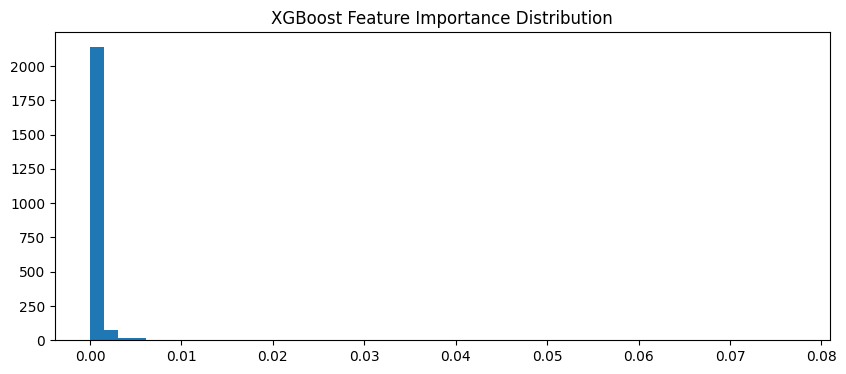

In [37]:
importances = xgb_model.feature_importances_
plt.figure(figsize=(10,4))
plt.hist(importances, bins=50)
plt.title("XGBoost Feature Importance Distribution")
plt.show()

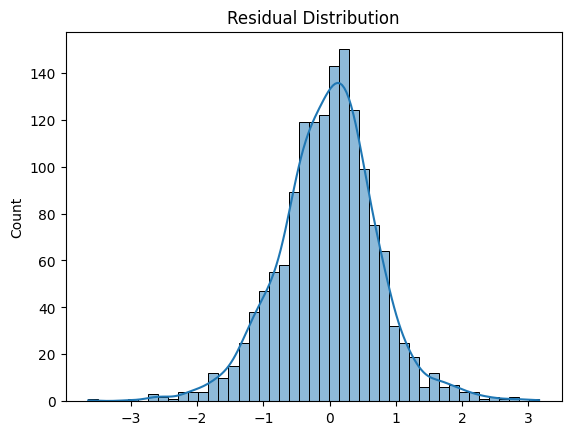

In [38]:
residuals = y_test - y_pred
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution")
plt.show()

In [39]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

ridge = Ridge(alpha=1.0)
ridge_cv = cross_val_score(ridge, X_train, y_train, cv=5, scoring='r2')

print("Ridge CV R²: {:.2f} ± {:.2f}".format(ridge_cv.mean(), ridge_cv.std()))

Ridge CV R²: 0.46 ± 0.04


In [40]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

# Predict on test set
y_pred = ridge.predict(X_test)

from sklearn.metrics import mean_squared_error, r2_score
print("Test R²:", r2_score(y_test, y_pred))
print("Test RMSE:", mean_squared_error(y_test, y_pred))

Test R²: 0.4855833475438658
Test RMSE: 0.9119759078622396


In [41]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),  # retain 95% variance
    ('ridge', Ridge(alpha=1.0))
])

cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2')
print("CV R² with PCA + Ridge: {:.2f} ± {:.2f}".format(cv_scores.mean(), cv_scores.std()))

CV R² with PCA + Ridge: 0.50 ± 0.01


In [42]:
# Fit the pipeline to access the trained components
pipeline.fit(X_train, y_train)

# Access the trained pca and ridge objects from the pipeline
pca_transform = pipeline.named_steps['pca']
ridge_model = pipeline.named_steps['ridge']

joblib.dump(pca_transform, "pca_transform.pkl")
joblib.dump(ridge_model, "ridge_pca_model.pkl")

['ridge_pca_model.pkl']

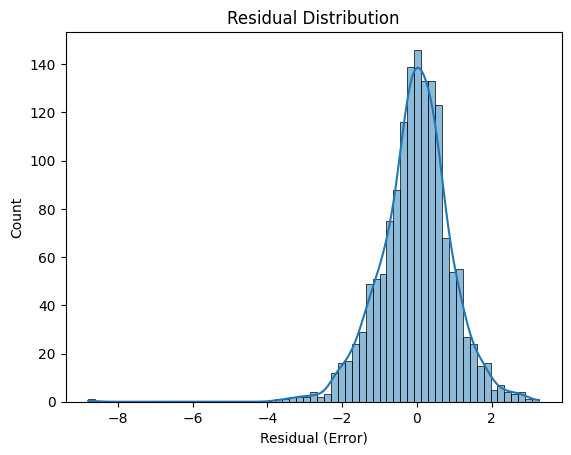

In [43]:
residuals = y_test - y_pred
sns.histplot(residuals, kde=True)
plt.xlabel("Residual (Error)")
plt.title("Residual Distribution")
plt.show()

In [44]:
import joblib
joblib.dump(ridge, "ridge_qsar_model.pkl")

['ridge_qsar_model.pkl']

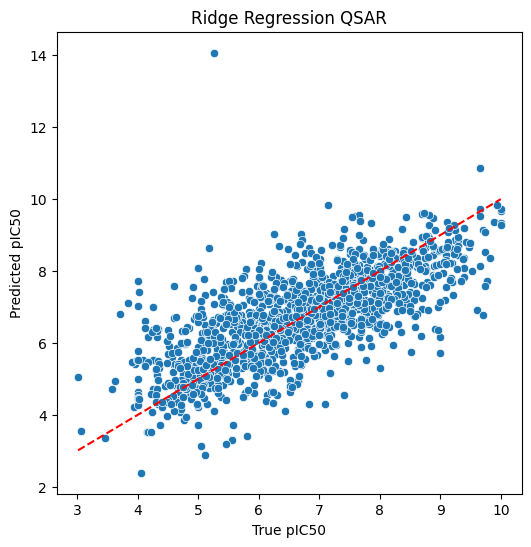

In [45]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel("True pIC50")
plt.ylabel("Predicted pIC50")
plt.title("Ridge Regression QSAR")
plt.savefig("ridge_qsar.png")
plt.show()